# **Face Recognition Systems**

1. Creating the datasets(Taking 100 Images)
2. Cropping only the face
3. Spliting file into training,valadation and testing
4. Data Augmentation and Preprocressing
5. Designing a model using pretrained model
6. Appropriate Hyperparameters
7. Fine-Tunning
8. Evaluate the model
9. Repeat the previous 3 steps until the valadation accuracy about 90%
10. Test the model real-time.

#### Import modeules

In [8]:
import random as rd
import os
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import itertools

import mediapipe as mp
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates


#### Functions

In [9]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt
def plot_loss_curves(history,model_name,savefig):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  if(savefig):
    os.makedirs("./Graph/"+model_name+"/",exist_ok=True)
    plt.savefig("./Graph/"+model_name+"/"+"Loss"+".png")
  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  if(savefig):
    plt.savefig("./Graph/"+model_name+"/"+"Accuracy"+".png")

In [10]:
def make_confusion_matrix(y_true, y_pred,file_name,classes=None, figsize=(10, 10), text_size=15, norm=False,savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm =tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("./Graph/Confusion_Matrix/"+file_name+".png")

### Paths

In [6]:
#Image paths
raw_data_dir="./Data/Raw_Images/"
raw_crop_dir="./Data/Raw_Cropped_Images/"

data_dir="./Data/Images/"
train_dir=data_dir+"train/"
val_dir=data_dir+"val/"
test_dir=data_dir+"test/"

crop_dir="./Data/Cropped_Images/"
train_crop_dir=crop_dir+"train/"
val_crop_dir=crop_dir+"val/"
test_crop_dir=crop_dir+"test/"

class_name=os.listdir(raw_data_dir)
print(class_name)

['Adyant', 'Atul', 'Balaji', 'Dasarath', 'Hari', 'Hemant']


#### Split file

In [46]:
#To split-file(raw_image)
splitfolders.ratio(raw_data_dir, output=data_dir,seed=42, ratio=(0.6,0.2,0.2), group_prefix=None, move=False) # default values

Copying files: 599 files [00:17, 34.88 files/s]


In [114]:
#To split-file(crop_image)
splitfolders.ratio(raw_crop_dir, output=crop_dir,seed=42, ratio=(0.6,0.2,0.2), group_prefix=None, move=False) # default values

Copying files: 527 files [00:05, 101.34 files/s]


## Dataset

#### Crop Image

In [7]:
#Initialize mediapipe
def mp_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable=False
    results=model.process(image)
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    image.flags.writeable=True
    return image, results

In [8]:
#Initalize the models
mp_holistic=mp.solutions.holistic #Holistic model
mp_drawing=mp.solutions.drawing_utils #Drawing Cosmitics

In [9]:
#Delete images without face
for label in class_name:
    print(label,end="\n")
    label_path=raw_data_dir+str(label)+"/"
    for img_name in os.listdir(label_path):
        print(img_name,end="\r")
        img_path=label_path+img_name
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            image, results = mp_detection(cv2.imread(img_path), holistic) 
            if (not results.face_landmarks):
                print("Delete image")
                os.remove(img_path)
                print("\n")
    print("\n")

Adyant
fd066570-d1f9-11ed-8044-30d04209a3df.jpg

Atul
e12dd0ef-c895-11ed-bac5-30d04209a3df.jpg

Balaji
c73995e6-c937-11ed-999a-30d04209a3df.jpg

Dasarath
505777a8-d1f9-11ed-b651-30d04209a3df.jpg

Hari
80f8b3d3-d1f9-11ed-ad93-30d04209a3df.jpg

Harish
5c2ca258-c88d-11ed-83b2-30d04209a3df.jpg

Hemant
d9418b87-ed91-11ed-848d-30d04209a3df.jpg



In [111]:
#To Crop image
class_name=os.listdir(raw_data_dir)
for label in class_name:
    print(label,end="\n")
    temp_path=raw_data_dir+label+"/"
    crop_path=raw_crop_dir+label+"/"

    os.makedirs(crop_path, exist_ok=True)
    for file in os.listdir(temp_path):
        x=[]
        y=[]
        file_path=temp_path+file
        temp=cv2.imread(file_path)
        image_row,image_col,image_color=temp.shape

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            image, results = mp_detection(temp, holistic)
            ls_single_face=results.face_landmarks.landmark
            for idx in ls_single_face:
                cord = _normalized_to_pixel_coordinates(idx.x,idx.y,image_col,image_row)
                if(cord):
                    x.append(cord[0])
                    y.append(cord[1])
            cropped_image = image[min(y):max(y),min(x):max(x)]
            img_name=crop_path+file
            print(file,end="\r")
            cv2.imwrite(img_name,cropped_image)
    print("\n")

Adyant
fd066570-d1f9-11ed-8044-30d04209a3df.jpg

Atul
e12dd0ef-c895-11ed-bac5-30d04209a3df.jpg

Balaji
c73995e6-c937-11ed-999a-30d04209a3df.jpg

Dasarath
505777a8-d1f9-11ed-b651-30d04209a3df.jpg

Hari
80f8b3d3-d1f9-11ed-ad93-30d04209a3df.jpg

Harish
5c2ca258-c88d-11ed-83b2-30d04209a3df.jpg

Hemant
c8b80967-c88c-11ed-b5a1-30d04209a3df.jpg



#### Visualize

In [5]:
# No of raw_images
sum=0
for dirpath, dirnames, filenames in os.walk(raw_data_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in train=",sum,"\n")


There are  6 folders and 0 images in  ./Data/Raw_Images/
There are  0 folders and 99 images in  ./Data/Raw_Images/Adyant
There are  0 folders and 100 images in  ./Data/Raw_Images/Atul
There are  0 folders and 100 images in  ./Data/Raw_Images/Balaji
There are  0 folders and 100 images in  ./Data/Raw_Images/Dasarath
There are  0 folders and 100 images in  ./Data/Raw_Images/Hari
There are  0 folders and 100 images in  ./Data/Raw_Images/Hemant
No of images in train= 599 



In [6]:
# No of Images
sum=0
print("Train")
for dirpath, dirnames, filenames in os.walk(train_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in train=",sum,"\n")

sum=0
print("Val")
for dirpath, dirnames, filenames in os.walk(val_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in val=",sum,"\n")

sum=0
print("Test")
for dirpath, dirnames, filenames in os.walk(test_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in test=",sum,"\n")

Train
There are  6 folders and 0 images in  ./Data/Images/train/
There are  0 folders and 59 images in  ./Data/Images/train/Adyant
There are  0 folders and 60 images in  ./Data/Images/train/Atul
There are  0 folders and 60 images in  ./Data/Images/train/Balaji
There are  0 folders and 60 images in  ./Data/Images/train/Dasarath
There are  0 folders and 60 images in  ./Data/Images/train/Hari
There are  0 folders and 60 images in  ./Data/Images/train/Hemant
No of images in train= 359 

Val
There are  6 folders and 0 images in  ./Data/Images/val/
There are  0 folders and 19 images in  ./Data/Images/val/Adyant
There are  0 folders and 20 images in  ./Data/Images/val/Atul
There are  0 folders and 20 images in  ./Data/Images/val/Balaji
There are  0 folders and 20 images in  ./Data/Images/val/Dasarath
There are  0 folders and 20 images in  ./Data/Images/val/Hari
There are  0 folders and 20 images in  ./Data/Images/val/Hemant
No of images in val= 119 

Test
There are  6 folders and 0 images in 

#### Visualize

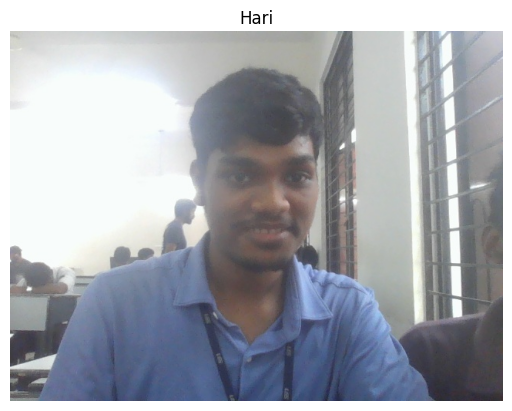

In [72]:
#Visualize image
label=class_name[rd.randint(0,len(class_name)-1)]
img_name=os.listdir(raw_data_dir+label+"/")[rd.randint(0,len(os.listdir(raw_data_dir+label))-1)]
img_file=raw_data_dir+label+"/"+img_name
plt.imshow(plt.imread(img_file))
plt.title(label)
plt.axis('off');

### Crop_Image Files

In [119]:
# No of crop_images
sum=0
for dirpath, dirnames, filenames in os.walk(raw_crop_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in train=",sum,"\n")

There are  7 folders and 0 images in  ./Data/Raw_Cropped_Images/
There are  0 folders and 99 images in  ./Data/Raw_Cropped_Images/Adyant
There are  0 folders and 100 images in  ./Data/Raw_Cropped_Images/Atul
There are  0 folders and 100 images in  ./Data/Raw_Cropped_Images/Balaji
There are  0 folders and 100 images in  ./Data/Raw_Cropped_Images/Dasarath
There are  0 folders and 100 images in  ./Data/Raw_Cropped_Images/Hari
There are  0 folders and 7 images in  ./Data/Raw_Cropped_Images/Harish
There are  0 folders and 21 images in  ./Data/Raw_Cropped_Images/Hemant
No of images in train= 527 



In [120]:
# No of Images
sum=0
print("Train")
for dirpath, dirnames, filenames in os.walk(train_crop_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in train=",sum,"\n")

sum=0
print("Val")
for dirpath, dirnames, filenames in os.walk(val_crop_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in val=",sum,"\n")

sum=0
print("Test")
for dirpath, dirnames, filenames in os.walk(test_crop_dir):
    print("There are ", len(dirnames),"folders and",len(filenames),"images in ", dirpath)
    sum=sum+len(filenames)
print("No of images in test=",sum,"\n")

Train
There are  7 folders and 0 images in  ./Data/Cropped_Images/train/
There are  0 folders and 59 images in  ./Data/Cropped_Images/train/Adyant
There are  0 folders and 60 images in  ./Data/Cropped_Images/train/Atul
There are  0 folders and 60 images in  ./Data/Cropped_Images/train/Balaji
There are  0 folders and 60 images in  ./Data/Cropped_Images/train/Dasarath
There are  0 folders and 60 images in  ./Data/Cropped_Images/train/Hari
There are  0 folders and 4 images in  ./Data/Cropped_Images/train/Harish
There are  0 folders and 12 images in  ./Data/Cropped_Images/train/Hemant
No of images in train= 315 

Val
There are  7 folders and 0 images in  ./Data/Cropped_Images/val/
There are  0 folders and 19 images in  ./Data/Cropped_Images/val/Adyant
There are  0 folders and 20 images in  ./Data/Cropped_Images/val/Atul
There are  0 folders and 20 images in  ./Data/Cropped_Images/val/Balaji
There are  0 folders and 20 images in  ./Data/Cropped_Images/val/Dasarath
There are  0 folders and 2

#### Visualize

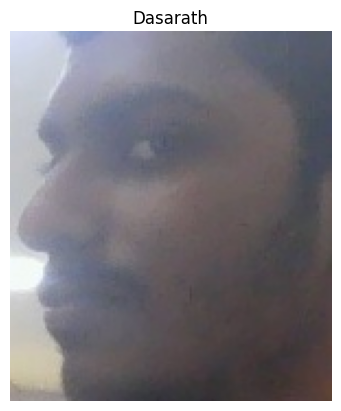

In [124]:
#Visualize image
label=class_name[rd.randint(0,len(class_name)-1)]
img_name=os.listdir(raw_crop_dir+label+"/")[rd.randint(0,len(os.listdir(raw_crop_dir+label))-1)]
img_file=raw_crop_dir+label+"/"+img_name
plt.imshow(plt.imread(img_file))
plt.title(label)
plt.axis('off');

## Image Preprocessing

### Raw Images

In [7]:
# Rescale the data and create data generator instances
IMG_SIZE = (480, 640, 3)
IMG=(480,640)
# Load data in from directories and turn it into batches
train_data =tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                image_size=IMG,
                                                                batch_size=32,
                                                                label_mode='categorical') # changed to categorical

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               image_size=IMG,
                                                               batch_size=32,
                                                               label_mode='categorical')
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG,
                                                               batch_size=32,
                                                               label_mode='categorical')


Found 359 files belonging to 6 classes.
Found 119 files belonging to 6 classes.
Found 121 files belonging to 6 classes.


In [48]:
t=np.array(plt.imread("D:/Visual/Project/Image_Classification/Face/Data/Raw_Images copy/Adyant/5af45246-c936-11ed-af63-30d04209a3df.jpg"))
np.shape(t)

(480, 640, 3)

### Cropped Images

In [136]:
#Rescale the data and create data generator instances
IMG_SIZE = (480, 640, 3)
IMG=(480,640)

# Load data in from directories and turn it into batches
train_data =tf.keras.preprocessing.image_dataset_from_directory(train_crop_dir,
                                                                image_size=IMG,
                                                                batch_size=32,
                                                                label_mode='categorical') # changed to categorical

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_crop_dir,
                                                               image_size=IMG,
                                                               batch_size=32,
                                                               label_mode='categorical')
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_crop_dir,
                                                               image_size=IMG,
                                                               batch_size=32,
                                                               label_mode='categorical')

Found 315 files belonging to 7 classes.
Found 104 files belonging to 7 classes.
Found 108 files belonging to 7 classes.


In [142]:
raw_data =tf.keras.preprocessing.image_dataset_from_directory(raw_data_dir,
                                                               image_size=IMG,
                                                               batch_size=32,
                                                               label_mode='categorical')

Found 527 files belonging to 7 classes.


## Model

#### Augmentation Layer

In [11]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Create a functional model with data augmentation
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  #preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

##### Visualize

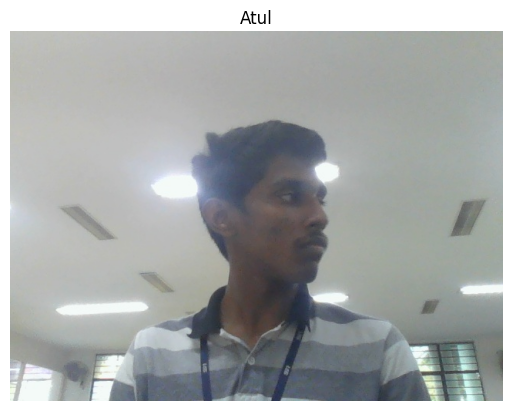

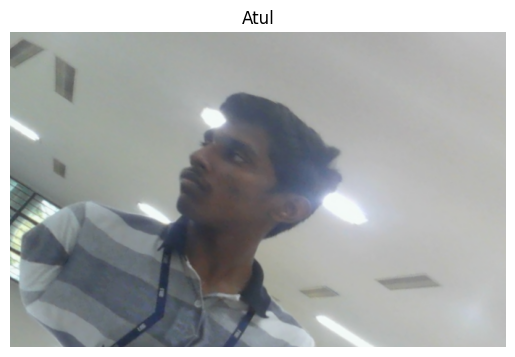

In [50]:
#Visualize image
#label=class_name[rd.randint(0,len(class_name)-1)]
label="Atul"
img_name=os.listdir(raw_data_dir+label+"/")[rd.randint(0,len(os.listdir(raw_data_dir+label))-1)]
img_file=raw_data_dir+label+"/"+img_name
plt.imshow(plt.imread(img_file))
plt.title(label)
plt.axis('off');

aug=data_augmentation(plt.imread(img_file),training=True)
plt.figure()
plt.imshow(np.array(aug,dtype=int))
plt.title(label)
plt.axis('off');

### EfficientNet Architecture
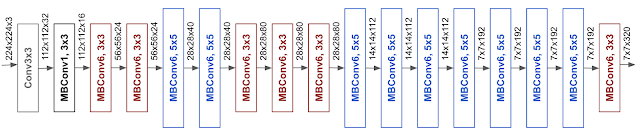

In [12]:
from tensorflow.keras import layers
IMG_SIZE=(480, 640, 3)
model_name="Efficient_B1"

#Base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# Setup the input shape to our model

# Create input and output layers
inputs = layers.Input(shape=IMG_SIZE, name="input_layer") # create input layer

x = data_augmentation(inputs,training=True) # augment our training images

x = base_model(x, training=False, name="base_model") # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(len(class_name), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [27]:
from tensorflow.keras import layers
model_name="Normal_CNN1"

base_model= Sequential([
  layers.Conv2D(128, 3, activation='relu', input_shape=(224, 224, 3)),
  
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
            padding="valid"), # padding can also be 'same'
  
  layers.Conv2D(128, 3, activation='relu'),
  
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
            padding="valid"), # padding can also be 'same'

  layers.Conv2D(128, 3, activation='relu'),
  
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
            padding="valid"), # padding can also be 'same'
  
])

inputs = layers.Input(shape=IMG_SIZE, name="input_layer") # create input layer

x = data_augmentation(inputs) # augment our training images

x = base_model(x) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(len(class_name), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [43]:
print(len(class_name))

6


In [9]:
base_model.save("./Model/base_model.h5")

#### Summary

In [52]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_5 (Rescaling)        (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_5 (Normalization  (None, None, None,   7          ['rescaling_5[0][0]']            
 )                              3)                                                   

In [ ]:
base_model.save("./Model/Base_CNN.h5")

In [130]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-traina

### Fit Model

In [10]:
#Call back
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
# Setup checkpoint path
checkpoint_path = "./Checkpoint/"+model_name+"/checkpoint.ckpt"

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)



# Fit the model saving checkpoints every epoch
initial_epochs=30
history=model.fit(train_data,
                                          epochs=initial_epochs,
                                          validation_data=val_data,
                                          validation_steps=int(len(val_data)), # do less steps per validation (quicker)
                                          callbacks=[checkpoint_callback, es])

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 1.5944 - accuracy: 0.4930 
Epoch 1: val_loss improved from inf to 1.26020, saving model to ./Checkpoint/Efficient_B0\checkpoint.ckpt
12/12 [==============================] - 398s 23s/step - loss: 1.5944 - accuracy: 0.4930 - val_loss: 1.2602 - val_accuracy: 0.7815
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 1.0068 - accuracy: 0.8858 
Epoch 2: val_loss improved from 1.26020 to 0.88399, saving model to ./Checkpoint/Efficient_B0\checkpoint.ckpt
12/12 [==============================] - 209s 17s/step - loss: 1.0068 - accuracy: 0.8858 - val_loss: 0.8840 - val_accuracy: 0.8403
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.9220 
Epoch 3: val_loss improved from 0.88399 to 0.65536, saving model to ./Checkpoint/Efficient_B0\checkpoint.ckpt
12/12 [==============================] - 172s 14s/step - loss: 0.6746 - accuracy: 0.9220 - val_loss: 0.6554 - val_accuracy: 0.8

In [15]:
model.load_weights(checkpoint_path)

In [14]:
model.save("./Model/"+model_name+".h5")

#### Plot graph

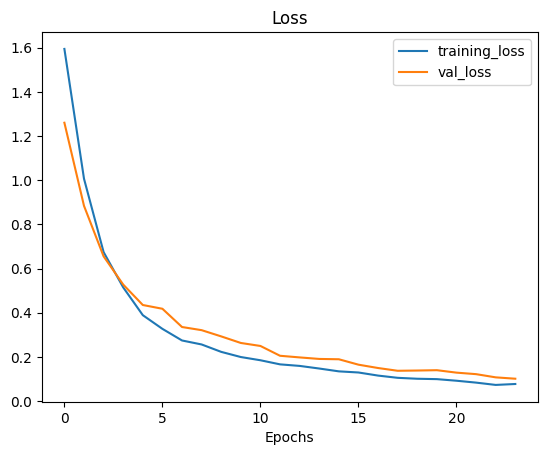

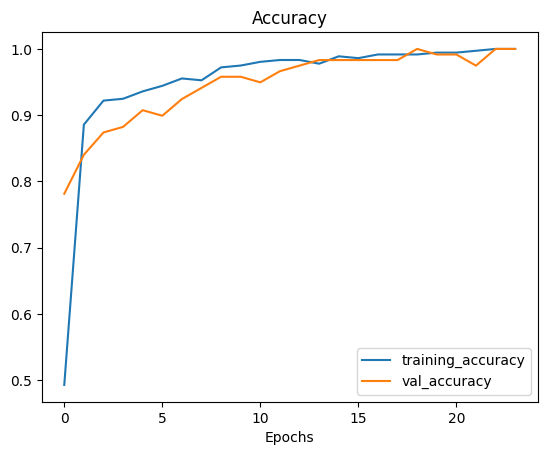

In [11]:
plot_loss_curves(history,model_name,savefig=True)

#### Confusion Matrix

In [16]:
predictions = np.array([])
label =  np.array([])

for x, y in test_data:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  label = np.concatenate([label, np.argmax(y.numpy(), axis=-1)])

for x, y in val_data:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  label = np.concatenate([label, np.argmax(y.numpy(), axis=-1)])

make_confusion_matrix(y_true=label, y_pred=predictions,file_name=model_name,classes=class_name, figsize=(10, 10), text_size=15, norm=False,savefig=False)

1/1 [==============================] - 9s 9s/step


In [13]:
model.evaluate(test_data)

4/4 [==============================] - 47s 11s/step - loss: 0.0931 - accuracy: 0.9917


[0.09313755482435226, 0.9917355179786682]